In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image
# default: 100
mpl.rcParams['figure.dpi'] = 150
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### SimCLR 与 InfoNCE

- Simple Framework for Contrastive Learning of Visual Representations
    - https://arxiv.org/abs/2002.05709
- Representation Learning with Contrastive Predictive Coding
    - https://arxiv.org/pdf/1807.03748

## softmax with temperature

In [2]:
def softmax_with_t(x, T):
    return np.exp(x/T)/sum(np.exp(x/T))

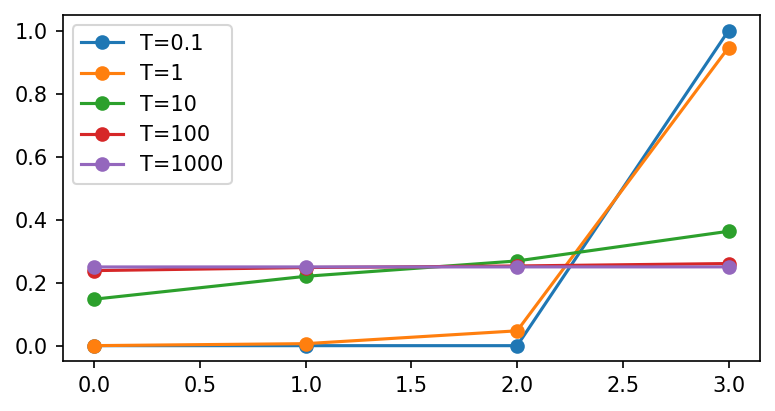

In [3]:
plt.figure(figsize=(6, 3))
logits = np.asarray([1, 5, 7, 10])
Ts = [0.1, 1, 10, 100, 10000]
for T in Ts:
    plt.plot(softmax_with_t(logits, T), '-o')
plt.legend(['T=0.1', 'T=1', 'T=10', 'T=100', 'T=1000'])

## NCE => InfoNCE

- NCE: noise contrastive estimation
- MoCo: https://arxiv.org/abs/1911.05722
    - $\tau=0.07$

$$
\text{Loss}=-\log\frac{\exp(q\cdot k_+/\tau)}{\sum_{i=0}^K\exp(q\cdot k_i/\tau)}
$$

If we do not use the temperature parameter, suppose that the dot product of negative pairs are -1 ($q\cdot k_-=-1$), and dot product of positive pair is 1 ($q\cdot k_+=1$), and we have K = 1024, in this case, the model has separated the positive and negative pairs perfectly, but the softmax loss is still too large （不必要的惩罚）:
 
$$
-\log \frac{\exp(1)}{\exp(1)+1023\exp(-1)}=4.94
$$

$$
-\log \frac{\exp(1/0.07)}{\exp(1/0.07)+1023\exp(-1/0.07)}=0
$$